In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score 
import warnings
warnings.filterwarnings('ignore')


In [2]:
df_census = pd.read_csv('census_cleaned.csv')
X_census, y_census = df_census.iloc[:,:-1], df_census.iloc[:,-1]

rf = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)
scores = cross_val_score(rf, X_census, y_census, cv=5)

print(f"Accuracy: {np.round(scores, 3)}")
print(f"Accuracy mean: {scores.mean():.3f}")


Accuracy: [0.844 0.842 0.853 0.855 0.755]
Accuracy mean: 0.830


In [3]:
from sklearn.ensemble import RandomForestRegressor

df_bikes = pd.read_csv('./bike_rentals_cleaned.csv')
X_bikes, y_bikes = df_bikes.iloc[:,:-1], df_bikes.iloc[:,-1]

rf = RandomForestRegressor(n_estimators=10, random_state=2, n_jobs=-1)
scores =cross_val_score(rf, X_bikes, y_bikes,
                        scoring='neg_mean_squared_error', cv=10)
rmse = np.sqrt(-scores)
print(f"RMSE: {np.round(rmse, 3)}")
print(f"RMSE mean: {rmse.mean():.3f}")


RMSE: [ 801.486  579.987  551.347  846.698  895.05  1097.522  893.738  809.284
  833.488 2145.046]
RMSE mean: 945.365


In [4]:
rf = RandomForestClassifier(oob_score=True, n_estimators=10, random_state=2,
                            n_jobs=-1)
rf.fit(X_census, y_census)
rf.oob_score_

0.8322533091735512

In [5]:
rf = RandomForestClassifier(n_estimators=50, oob_score=True, 
                            random_state=2, n_jobs=-1)
rf.fit(X_census, y_census)
rf.oob_score_

0.8557783851847302

In [6]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, 
                            random_state=2, n_jobs=-1)
rf.fit(X_census, y_census)
rf.oob_score_

0.8582660237707687

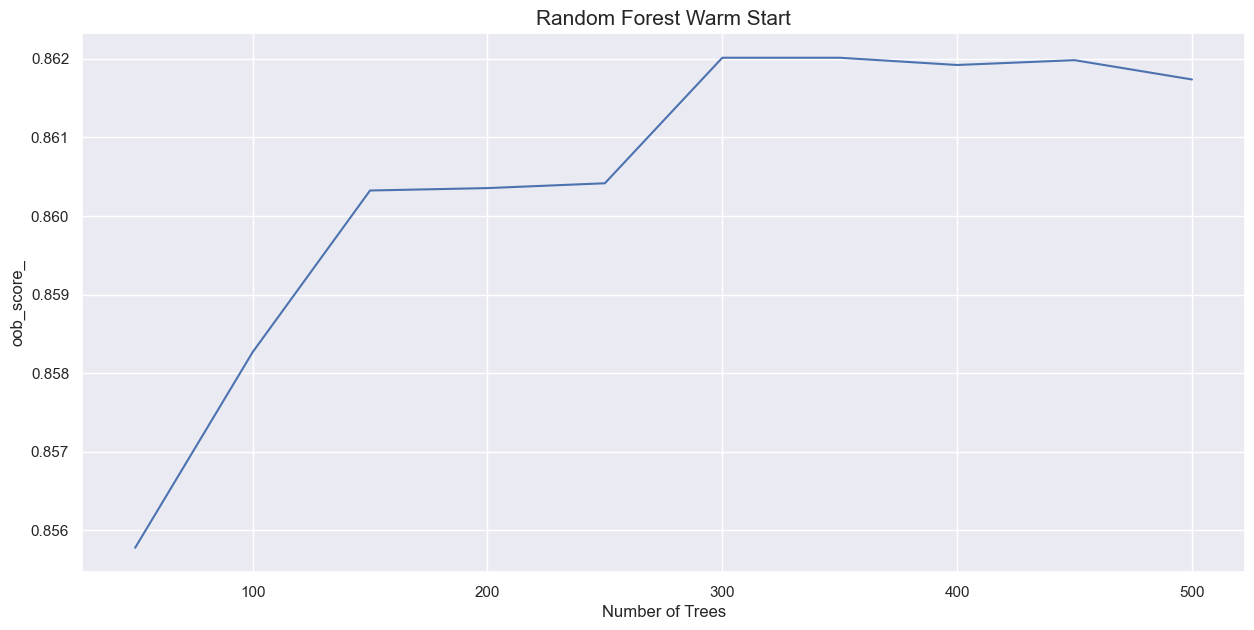

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

oob_scores = []
rf = RandomForestClassifier(n_estimators=50, warm_start=True, 
                            oob_score=True, n_jobs=-1, random_state=2)

rf.fit(X_census, y_census)
oob_scores.append(rf.oob_score_)

est = 50
estimators = [est]

for i in range(9):
  est += 50
  estimators.append(est)
  rf.set_params(n_estimators=est)
  rf.fit(X_census, y_census)
  oob_scores.append(rf.oob_score_)

plt.figure(figsize=(15,7))
plt.plot(estimators, oob_scores)
plt.xlabel('Number of Trees')
plt.ylabel('oob_score_')
plt.title('Random Forest Warm Start', fontsize=15)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bikes, 
                                                    y_bikes, random_state=2)


In [11]:
rf = RandomForestRegressor(n_estimators=50, warm_start=True,
                           n_jobs=-1, random_state=2)
scores = cross_val_score(rf, X_bikes, y_bikes, 
                         scoring='neg_mean_squared_error', cv=10)
rmse = np.sqrt(-scores)
print(f"RMSE: {np.round(rmse, 3)}")
print(f"RMSE mean: {rmse.mean():.3f}")


RMSE: [ 836.482  541.898  533.086  812.782  894.877  881.117  794.103  828.968
  772.517 2128.148]
RMSE mean: 902.398


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE

def randomized_search_reg(params, runs=16, 
                          reg=RandomForestRegressor(random_state=2, n_jobs=-1)):
  rand_reg = RandomizedSearchCV(reg, params, n_iter=runs, 
                                scoring='neg_mean_squared_error', 
                                cv=10, n_jobs=-1, random_state=2)
  rand_reg.fit(X_train, y_train)
  best_model = rand_reg.best_estimator_
  best_params = rand_reg.best_params_
  print(f"Best prams: {best_params}")
  best_score = np.sqrt(-rand_reg.best_score_)
  print(f"Training score: {best_score:.3f}")
  y_pred = best_model.predict(X_test)
  
  rmse_test = MSE(y_test, y_pred) ** 0.5
  print(f"Test set score: {rmse_test:.3f}")

randomized_search_reg(params={
    'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
    'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
    'min_samples_leaf':[1,2,4,6,8,10,20,30],
    'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
    'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None], 
    'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
    'max_depth':[None,2,4,6,8,10,20]})

Best prams: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.03, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 25, 'max_features': 0.7, 'max_depth': None}
Training score: 759.076
Test set score: 701.802


In [13]:
randomized_search_reg(params={
    'min_samples_leaf': [1,2,4,6,8,10,20,30], 
    'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
    'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4], 
    'max_depth':[None,2,4,6,8,10,20]})

Best prams: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 10}
Training score: 679.052
Test set score: 626.541


In [14]:
randomized_search_reg(params={
    'min_samples_leaf':[1,2,4,6,8,10,20,30],
    'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
    'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
    'max_depth':[None,4,6,8,10,12,15,20]}, runs=20)

Best prams: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
Training score: 675.128
Test set score: 619.014


In [15]:
randomized_search_reg(params={
    'min_samples_leaf':[1,2,3,4,5,6], 
    'min_impurity_decrease':[0.0, 0.01, 0.05, 0.08, 0.10, 0.12, 0.15], 
    'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
    'max_depth':[None,8,10,12,14,16,18,20]})


Best prams: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.05, 'max_features': 0.7, 'max_depth': 18}
Training score: 679.595
Test set score: 630.954


In [16]:
randomized_search_reg(params={
    'min_samples_leaf':[1,2,4,6,8,10,20,30], 
    'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2], 
    'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
    'max_depth':[None,4,6,8,10,12,15,20],
    'n_estimators':[100]}, runs=20)


Best prams: {'n_estimators': 100, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
Training score: 675.128
Test set score: 619.014


In [18]:
rf = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.1,
                           max_features=0.6, max_depth=12, warm_start=True,
                           n_jobs=-1, random_state=2)
scores = cross_val_score(rf, X_bikes, y_bikes, 
                         scoring='neg_mean_squared_error', cv=10)
rmse = np.sqrt(-scores)
print(f"RMSE: {np.round(rmse, 3)}")
print(f"RMSE mean: {rmse.mean():.3f}")


RMSE: [ 818.354  514.173  547.392  814.059  769.54   730.025  831.376  794.634
  756.83  1595.237]
RMSE mean: 817.162


In [19]:
from sklearn.utils import shuffle 
df_shuffle_bikes = shuffle(df_bikes, random_state=2)

X_shuffle_bikes = df_shuffle_bikes.iloc[:,:-1]
y_shuffle_bikes = df_shuffle_bikes.iloc[:,-1]

rf = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.1, 
                           max_features=0.6, max_depth=12, n_jobs=-1, 
                           random_state=2)
scores = cross_val_score(rf, X_shuffle_bikes, y_shuffle_bikes, 
                         scoring='neg_mean_squared_error', cv=10)

rmse = np.sqrt(-scores)
print(f"RMSE: {np.round(rmse, 3)}")
print(f"RMSE mean: {rmse.mean():.3f}")


RMSE: [630.093 686.673 468.159 526.676 593.033 724.575 774.402 672.63  760.253
 616.797]
RMSE mean: 645.329
